In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from typing import Optional
from tqdm import tqdm
from numpy.typing import NDArray
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim import Optimizer, AdamW
from torch.optim.lr_scheduler import LinearLR, LRScheduler, ExponentialLR
from torch.utils.data import Dataset
from torch.nn import Module
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
X = None
y = None
with open('../dirs.yaml', 'r') as file:
    dirs = yaml.safe_load(file)['homework-1']
    X = pd.read_csv(dirs['train']['x'])
    y = pd.read_csv(dirs['train']['y'])
    
df = pd.merge(X, y, on='Unnamed: 0').drop(columns=['Unnamed: 0'])
X = df.drop(columns=['year'])
y = df['year']

In [3]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,year
0,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,-0.46428,...,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682,2001
1,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,-5.58019,...,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676,2006
2,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,10.75028,...,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276,1989
3,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,-4.29075,...,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130,1997
4,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,31.69655,...,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840,2001
5,52.33593,2.89543,56.90252,8.96987,-25.76965,-15.71307,3.50595,-8.96479,1.19235,-4.97747,...,37.47755,-14.58737,120.49606,-14.30169,-75.96685,40.57184,0.99512,60.78252,-15.17380,2009
6,50.93086,2.40169,35.79261,-0.07677,-40.96232,-17.04343,-10.91591,-11.32212,4.69807,-2.25197,...,-110.61446,-60.67350,4.09050,1.17609,-89.90531,50.88912,-6.94646,174.95178,26.32797,2009
7,44.11978,11.85193,57.67591,-14.54233,4.04202,6.18560,-12.82692,4.09408,11.87608,2.09057,...,-64.08981,396.40911,312.23906,10.09221,-220.19327,144.47076,29.26308,-717.40632,45.79519,2000
8,40.79316,39.50647,27.37837,-11.96658,-5.43111,-6.25519,0.21025,5.37451,9.27321,10.06320,...,30.89832,185.94793,55.47131,12.10047,-35.04364,15.84014,4.84509,48.40314,-7.48619,1976
9,38.31416,-28.59876,-1.87686,-10.30072,11.44784,1.15831,-20.47703,-2.45890,9.27336,-1.97484,...,-44.63124,93.55093,84.37248,-10.88730,-33.68677,-57.70108,13.22433,-51.66323,11.02160,1994


In [4]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,year
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,43.394558,1.540279,8.378243,1.315349,-6.476035,-9.503415,-2.243164,-1.660698,3.543946,1.892996,...,-72.008182,41.154440,37.892338,0.145765,17.576243,-28.502296,4.474666,17.717701,1.227647,1998.366714
std,6.074562,51.578894,35.742553,16.622971,22.823521,12.926176,14.700348,8.035388,10.629817,6.602191,...,171.932584,120.075095,96.748418,16.162963,115.706029,180.463987,13.592096,185.335542,22.018997,11.048088
min,7.199890,-302.031900,-257.525600,-120.723150,-142.160680,-60.198620,-100.602550,-51.443820,-75.539550,-31.344160,...,-1976.846950,-791.832320,-1237.931680,-227.608010,-2678.193680,-3059.906060,-100.618700,-5000.654060,-286.031200,1922.000000
25%,39.970260,-25.603507,-11.773080,-8.490435,-20.716735,-18.524397,-10.651808,-6.402985,-2.573275,-2.446435,...,-138.560657,-21.424297,-4.443660,-7.027105,-32.236598,-101.305695,-2.563620,-60.364940,-8.873683,1994.000000
50%,44.282770,8.800720,10.226865,-0.582025,-5.808040,-11.254920,-2.007255,-1.516640,3.658655,1.763500,...,-52.984525,29.218730,33.576620,0.770135,15.522650,-22.050410,3.021435,6.982460,-0.050725,2002.000000
75%,47.843418,36.610743,29.596557,9.035892,7.858092,-2.198952,6.725500,3.111740,9.935210,6.245860,...,14.405743,89.374030,78.710667,8.380725,66.429958,50.378898,9.912000,86.542642,9.664982,2006.000000
max,57.408630,240.617010,318.868960,143.841600,142.305480,68.300090,147.965260,52.331120,78.149440,36.596180,...,1081.951340,1473.745210,1458.580210,199.121500,1620.749740,1879.332480,352.359540,3165.372860,245.209770,2011.000000


**Выводы:**
 1) Наибольшее число песен в диапазоне от 1994 до 2006
 3) У некоторых данных достаточно большая дисперсия

Из [предоставленого источника](https://archive.ics.uci.edu/dataset/203/yearpredictionmsd) можно узнать, что в датасете:
90 атрибутов, 12 = средний тон, 78 = ковариация тона
Первое значение — год (целевая переменная), диапазон от 1922 до 2011.
Характеристики, извлеченные из 'timbre' характеристик API The Echo Nest.
Берется среднее значение и ковариацию для всех 'сегментов', каждый сегмент
описывается 12-мерным вектором timbre. 

**Пояснение:**

Пусть трек состоит из $N$ сегментов, тогда можно записать в виде матрицы:
$$
\begin{pmatrix} t_{1,1} & ... & t_{1,12} \\ ... & ... & .. \\ t_{N,1} & ... & t_{N,12} \end{pmatrix}
$$
Тогда:

Первые 12 значений:
$$
\mu = \frac{1}{N}\sum\limits_{i=1}^NT_i \\
\Sigma = \frac{1}{N-1}(T - 1\mu^T)^T(T - 1\mu^T)
$$

78 - чтобы не повторять значения

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 91 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14000 non-null  float64
 1   1       14000 non-null  float64
 2   2       14000 non-null  float64
 3   3       14000 non-null  float64
 4   4       14000 non-null  float64
 5   5       14000 non-null  float64
 6   6       14000 non-null  float64
 7   7       14000 non-null  float64
 8   8       14000 non-null  float64
 9   9       14000 non-null  float64
 10  10      14000 non-null  float64
 11  11      14000 non-null  float64
 12  12      14000 non-null  float64
 13  13      14000 non-null  float64
 14  14      14000 non-null  float64
 15  15      14000 non-null  float64
 16  16      14000 non-null  float64
 17  17      14000 non-null  float64
 18  18      14000 non-null  float64
 19  19      14000 non-null  float64
 20  20      14000 non-null  float64
 21  21      14000 non-null  float64
 22

# Базовые классы

In [6]:
class MyDataset(Dataset):
    def __init__(self, X: NDArray, y: NDArray):
        super().__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
class DataLoaderGenerator:
    def __new__(cls,
                X: pd.DataFrame,
                y: pd.Series,
                batch_size: int = 64,
                shuffle: bool = True) -> DataLoader:
        return DataLoader(MyDataset(X, y), batch_size=batch_size, shuffle=shuffle)

In [ ]:
class ModelTrainer:
    def __init__(self,
                 num_epochs: int,
                 device: torch.device = torch.device('cpu')):
        self.num_epochs = num_epochs
        self.model = None
        self.train_loss_history = None
        self.test_loss_history = None
        self.device = device

    def __call__(self,
                 train_dataloader: DataLoader,
                 model: nn.Module,
                 optimizer: Optimizer,
                 criterion: nn.Module,
                 test_dataloader: Optional[DataLoader] = None,
                 scheduler: Optional[ExponentialLR] = None) -> float:
        self.model = model.to(self.device)
        self.model.train()
        self.train_loss_history = []
        self.test_loss_history = []
        with tqdm(total=len(train_dataloader) * self.num_epochs, unit="batch", position=0, leave=True) as pbar:
            for epoch in range(self.num_epochs):
                running_loss = 0.0
                for xb, yb in train_dataloader:
                    xb, yb = xb.to(self.device), yb.to(self.device)
    
                    optimizer.zero_grad()
                    outputs = model(xb)
                    loss = criterion(outputs, yb)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    pbar.set_postfix({
                        "Epoch": f"{epoch + 1}/{self.num_epochs}",
                        "Loss": f"{loss.item():.4f}"
                    })
                    pbar.update()

                avg_epoch_loss = running_loss / len(train_dataloader)
                self.train_loss_history.append(self.test(train_dataloader))
                if test_dataloader is not None:
                    self.test_loss_history.append(self.test(test_dataloader))
                self.model.train()
                pbar.set_postfix({"Epoch Loss": f"{avg_epoch_loss:.4f}"})
                
                if scheduler is not None:
                    scheduler.step()

            pbar.close()
        if test_dataloader is not None:
            return self.test(train_dataloader), self.test(test_dataloader)
        return self.test(train_dataloader)
    
    def test(self, dataloader: DataLoader) -> float:
        self.model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for xb, yb in dataloader:
                xb = xb.to(self.device)
                outputs = self.model(xb).cpu().numpy()
                y_true.extend(yb.numpy())
                y_pred.extend(outputs)

        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mse = mean_squared_error(y_true, y_pred)
        return mse

    def plot_loss_history(self, num_last_epoch: Optional[int] = None):
        if num_last_epoch is None:
            start_epoch = 0
        else:   
            start_epoch = len(self.train_loss_history) - num_last_epoch
        
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_loss_history[start_epoch:], label="Train Loss")
        if self.test_loss_history is not None:
            plt.plot(self.test_loss_history[start_epoch:], label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.title("Loss over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()


In [8]:
class FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_size, config.ffn_dim, config.bias)
        self.fc2 = nn.Linear(config.ffn_dim, config.hidden_size, config.bias)
        self.actvation_func = config.activation_func
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.dropout(self.actvation_func(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [9]:
class AddNorm(Module):
    def __init__(self, config):
        super().__init__()
        self.norm = nn.LayerNorm(config.hidden_size,
                                 config.eps,
                                 config.elementwise_affine,
                                 config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, sublayer_out):
        return self.norm(x + self.dropout(sublayer_out))

In [10]:
class MyLayer(Module):
    def __init__(self, config):
        super().__init__()
        self.ffn = FFN(config)
        self.add_norm = AddNorm(config)
        
    def forward(self, x: Tensor) -> Tensor:
        return self.add_norm(x, self.ffn(x))

# Решение "в лоб"

In [11]:
class ModelVer1(Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.ModuleList(
            [MyLayer(config)
             for _ in range(config.num_layers)]
            
        )
        self.in_linear = nn.Linear(config.in_features, config.hidden_size)
        self.out_linear = nn.Linear(config.hidden_size, 1)
        
    def forward(self, x: Tensor) -> Tensor:
        x = self.in_linear(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.out_linear(x)
        return logits.squeeze(-1)
        

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.1)

In [13]:
class Config:
    in_features = 90
    num_layers = 8
    hidden_size = 256
    ffn_dim = 512
    activation_func = nn.ReLU()
    eps: float = 10**(-5)
    elementwise_affine: bool = True
    dropout: float = 0.2
    bias: bool = True

In [14]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
train_dataloader = DataLoaderGenerator(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoaderGenerator(X_test, y_test, batch_size=BATCH_SIZE, shuffle=True)
model = ModelVer1(Config)
optimizer = AdamW(model.parameters())
criterion = nn.MSELoss()

trainer = ModelTrainer(num_epochs=NUM_EPOCHS, device=torch.device('cuda'))
train_mse, test_mse = trainer(train_dataloader, model, optimizer, criterion, test_dataloader=test_dataloader)
print(f"train MSE: {train_mse}\ntest MSE: {test_mse}")

100%|██████████| 7880/7880 [00:56<00:00, 139.03batch/s, Epoch Loss=106.2198]         


train MSE: 106.39346313476562
test MSE: 105.76060485839844


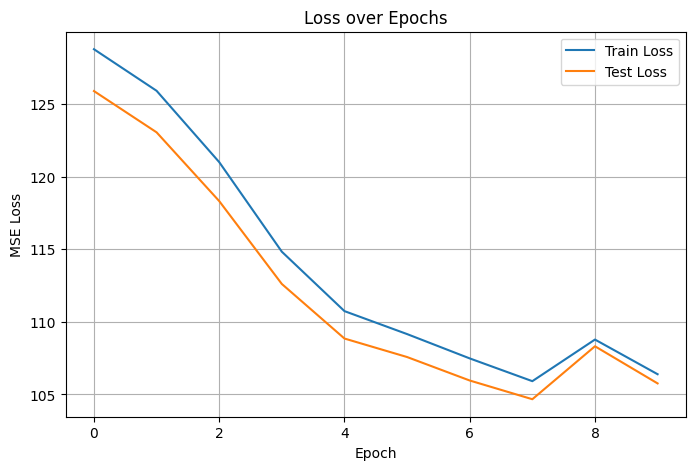

In [15]:
trainer.plot_loss_history(10)

##  Немного "поиграем" с параметрами

In [16]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
train_loader = DataLoaderGenerator(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoaderGenerator(X_test, y_test, batch_size=BATCH_SIZE, shuffle=True)

model = ModelVer1(Config)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
criterion = nn.MSELoss()
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=NUM_EPOCHS)

trainer = ModelTrainer(num_epochs=NUM_EPOCHS, device=torch.device('cuda'))
train_mse, test_mse = trainer(train_dataloader, model, optimizer, criterion, test_dataloader=test_dataloader)
print(f"train MSE: {train_mse}\ntest MSE: {test_mse}")

  0%|          | 11/7880 [00:00<00:50, 155.73batch/s, Epoch=1/20, Loss=3942924.5000]

100%|██████████| 7880/7880 [00:56<00:00, 139.42batch/s, Epoch Loss=104.2999]         


train MSE: 102.06500244140625
test MSE: 102.11610412597656


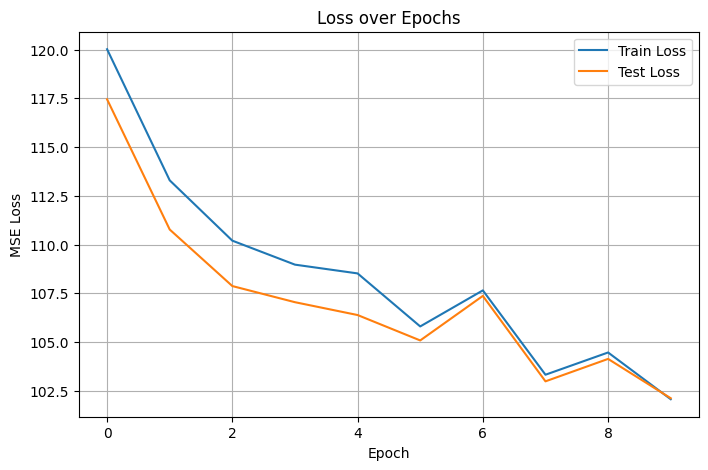

In [17]:
trainer.plot_loss_history(10)

## Попытка использовать MoE

In [75]:
class Config:
    in_features = 90
    num_layers = 8
    hidden_size = 256
    ffn_dim = 512
    activation_func = nn.ReLU()
    eps: float = 10**(-5)
    elementwise_affine: bool = True
    dropout: float = 0.3
    bias: bool = True
    num_experts: int = 8
    top_k: int = 4

In [76]:
class MoELayer(Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.num_experts = config.num_experts
        self.k = config.top_k
        
        self.gate = FFN(config)
        self.experts = nn.ModuleList(
            [FFN(config)
             for _ in range(self.num_experts)])
        
    def forward(self, x: Tensor) -> Tensor:
        batch_size, hidden_size = x.shape
        x_flat = x.view(-1, hidden_size)
        
        gate_probs = self.gate(x_flat)
        topk_probs, topk_idx = torch.topk(gate_probs, k=self.k)
        topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
        
        token_idx = torch.arange(x_flat.size(0), device=x.device) \
            .unsqueeze(1).expand(-1, self.k).reshape(-1)
        expert_idx = topk_idx.reshape(-1)                                                                                      
        probs = topk_probs.reshape(-1)      
    
        logits_flat = torch.zeros_like(x_flat)
        for e in range(len(self.experts)):
            mask = (expert_idx == e)
            if mask.any():
                idx_e = token_idx[mask] 
                w_e   = probs[mask]     
                out_e = self.experts[e](x_flat[idx_e]) * w_e.unsqueeze(1)
                logits_flat.index_add_(0, idx_e, out_e)
    
        logits = logits_flat.view(batch_size, hidden_size)
        return logits

In [77]:
class MyLayer(Module):
    def __init__(self, config):
        super().__init__()
        self.ffn = MoELayer(config)
        self.add_norm = AddNorm(config)
        
    def forward(self, x: Tensor) -> Tensor:
        return self.add_norm(x, self.ffn(x))

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 100
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
train_loader = DataLoaderGenerator(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoaderGenerator(X_test, y_test, batch_size=BATCH_SIZE, shuffle=True)

model = ModelVer1(Config)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

warmup_epochs = 10

warmup_scheduler = LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=warmup_epochs)
main_scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - warmup_epochs)

scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[warmup_epochs])

trainer = ModelTrainer(num_epochs=NUM_EPOCHS, device=torch.device('cuda'))
train_mse, test_mse = trainer(train_dataloader, model, optimizer, criterion, test_dataloader=test_dataloader)
print(f"train MSE: {train_mse}\ntest MSE: {test_mse}")

 68%|██████▊   | 13396/19700 [02:31<01:11, 88.52batch/s, Epoch=34/50, Loss=80.8118]   


KeyboardInterrupt: 

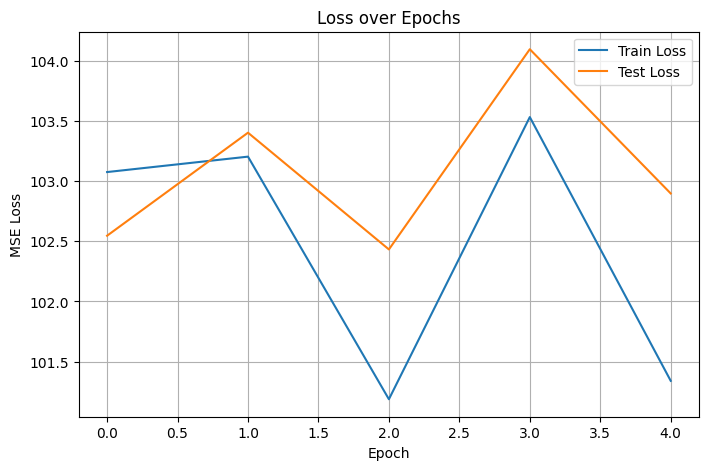

In [ ]:
trainer.plot_loss_history(5)